In [1]:
"""
Emotion-Driven Art Generation Pipeline

This script integrates several components:
1. Loads a pre-trained emotion classifier model (SBERT + VAD features).
2. Loads necessary resources (NRC-VAD Lexicon, spaCy).
3. Defines utility functions for VAD calculation and keyword extraction.
4. Implements rule-based emotion patching (keyword mapping, clustering).
5. Analyzes input text for emotions and VAD scores using the loaded model.
6. Generates a detailed abstract art prompt for Stable Diffusion XL based on
   emotions, VAD, keywords, and text themes.
7. Generates an image using Stable Diffusion XL.
8. Generates a textual description of the conceptual artwork using Gemini.

Ensure all paths, API keys, and the LABEL_NAMES list are correctly configured.
"""

'\nEmotion-Driven Art Generation Pipeline\n\nThis script integrates several components:\n1. Loads a pre-trained emotion classifier model (SBERT + VAD features).\n2. Loads necessary resources (NRC-VAD Lexicon, spaCy).\n3. Defines utility functions for VAD calculation and keyword extraction.\n4. Implements rule-based emotion patching (keyword mapping, clustering).\n5. Analyzes input text for emotions and VAD scores using the loaded model.\n6. Generates a detailed abstract art prompt for Stable Diffusion XL based on\n   emotions, VAD, keywords, and text themes.\n7. Generates an image using Stable Diffusion XL.\n8. Generates a textual description of the conceptual artwork using Gemini.\n\nEnsure all paths, API keys, and the LABEL_NAMES list are correctly configured.\n'

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from diffusers import StableDiffusionXLPipeline
import google.generativeai as genai
import spacy
from pathlib import Path
from huggingface_hub import login
from IPython.display import display 
from PIL import Image as PILImage 
import warnings
import collections 

In [ ]:
# --- Configuration ---

# === Paths ===
# Adjust these paths as needed
MODEL_ZIP_PATH = Path("/content/best_model.zip") 
EXTRACT_BASE_PATH = Path("/content/extracted_model") 
MODEL_CHECKPOINT_DIR = EXTRACT_BASE_PATH / "checkpoints" / "best_model" 
NRC_VAD_LEXICON_PATH = Path("NRC-VAD-Lexicon.txt") 

# === Model Identifiers ===
BASE_TRANSFORMER_MODEL = "sentence-transformers/all-MiniLM-L6-v2" 
SDXL_MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
GEMINI_MODEL_NAME = 'gemini-1.5-flash' 

# === Emotion Labels ===
# Derived from user input:
raw_labels = """
    excitement, surprise, trust, disappointment , sadness , neutral , caring  ,joy  ,
    admiration ,gratitude ,fear, approval, anger  ,annoyance, disapproval,
    amusement, curiosity, pride, embarrassed, confusion, lonely, guilty,
    furious, anxious, disgusted, confidence, anticipating, grief, hopeful,
    nostalgia, jealous, readiness, content, sentimental, love, shame,
    optimistic, realization, apprehensive, disgust, desire, guilt,
    nervousness, relief, happiness
"""
# Clean the list
LABEL_NAMES = sorted(list(set([label.strip() for label in raw_labels.replace('\n', '').split(',') if label.strip()])))

# Verify and set number of labels
if not LABEL_NAMES:
    raise ValueError("Emotion LABEL_NAMES list is empty after cleaning. Please provide valid labels.")
print(f"Using {len(LABEL_NAMES)} emotion labels: {LABEL_NAMES}")
NUM_LABELS = len(LABEL_NAMES)

# Check for duplicates (should be handled by set, but good practice)
if len(LABEL_NAMES) != len(set(LABEL_NAMES)):
     warnings.warn(f"Duplicate emotion labels found AFTER cleaning: {[item for item, count in collections.Counter(LABEL_NAMES).items() if count > 1]}")


✅ Using 45 emotion labels: ['admiration', 'amusement', 'anger', 'annoyance', 'anticipating', 'anxious', 'apprehensive', 'approval', 'caring', 'confidence', 'confusion', 'content', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'disgusted', 'embarrassed', 'excitement', 'fear', 'furious', 'gratitude', 'grief', 'guilt', 'guilty', 'happiness', 'hopeful', 'jealous', 'joy', 'lonely', 'love', 'nervousness', 'neutral', 'nostalgia', 'optimistic', 'pride', 'readiness', 'realization', 'relief', 'sadness', 'sentimental', 'shame', 'surprise', 'trust']


In [ ]:
# === API Keys  ===
HUGGINGFACE_TOKEN = "# YOUR_HF_TOKEN " 
GEMINI_API_KEY = "# YOUR_GEMINI_API_KEY" 

In [ ]:
# === Other Parameters ===
SDXL_IMAGE_HEIGHT = 1024
SDXL_IMAGE_WIDTH = 1024
SDXL_GUIDANCE_SCALE = 7.5
SDXL_NUM_INFERENCE_STEPS = 30 
PROMPT_MAX_CHAR_LENGTH = 250 
TOP_K_EMOTIONS_DISPLAY = 5
MAX_KEYWORDS = 5
TOKENIZER_MAX_LENGTH = 256 


In [ ]:
# --- Setup ---

# Check and Set Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16 
    print(f" Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32 
    print(" GPU not available, using CPU. Operations will be slower.")

# Optional: Hugging Face Login
if HUGGINGFACE_TOKEN:
    try:
        login(token=HUGGINGFACE_TOKEN)
        print("Hugging Face Hub login successful.")
    except Exception as e:
        print(f"Hugging Face Hub login failed: {e}. Proceeding without login.")
else:
    print("Hugging Face Hub token not provided. Skipping login.")

# Configure Gemini API
if GEMINI_API_KEY:
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        print("Google Gemini API configured successfully.")
    except Exception as e:
        print(f"Error configuring Gemini API: {e}. Description generation will fail.")
        GEMINI_API_KEY = None # Disable Gemini if configuration fails
else:
    print("Google Gemini API key not provided. Description generation will be skipped.")

✅ Using GPU: Tesla T4
✅ Hugging Face Hub login successful.
✅ Google Gemini API configured successfully.


In [ ]:
# --- Load Resources ---

# Extract Model Checkpoint
if MODEL_ZIP_PATH.exists():
    print(f"Extracting model from {MODEL_ZIP_PATH} to {EXTRACT_BASE_PATH}...")
    try:
        # Ensure extraction path exists
        EXTRACT_BASE_PATH.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(MODEL_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_BASE_PATH)
        print(f"Model extracted successfully to {EXTRACT_BASE_PATH}.")
        # Verify expected directory structure
        if not MODEL_CHECKPOINT_DIR.exists():
             print(f"Error: Expected checkpoint directory not found after extraction: {MODEL_CHECKPOINT_DIR}")
        else:
             print(f"Verified checkpoint directory: {MODEL_CHECKPOINT_DIR}")
    except Exception as e:
        print(f"Error extracting model: {e}")
else:
    print(f"Model zip file not found at {MODEL_ZIP_PATH}. Assuming model is already available at {MODEL_CHECKPOINT_DIR}.")


# Load NRC-VAD Lexicon
print("Loading NRC-VAD Lexicon...")
nrc_vad = None
if NRC_VAD_LEXICON_PATH.exists():
    try:
        nrc_vad_df = pd.read_csv(NRC_VAD_LEXICON_PATH, sep='\t', header=None)

        if nrc_vad_df.shape[1] == 4: 
             nrc_vad_df.columns = ["word", "valence", "arousal", "dominance"]
             nrc_vad_df.set_index("word", inplace=True)
             nrc_vad = nrc_vad_df 
        elif nrc_vad_df.shape[1] == 3: 
             nrc_vad_df.columns = ["valence", "arousal", "dominance"]
             # Requires index col to be set correctly when loading or file format assumption
             if nrc_vad_df.index.name is None or nrc_vad_df.index.name.lower() != "word":
                  # Try to load again assuming first column is index
                  nrc_vad_df = pd.read_csv(NRC_VAD_LEXICON_PATH, sep='\t', header=None, index_col=0)
                  if nrc_vad_df.shape[1] == 3:
                       nrc_vad_df.columns = ["valence", "arousal", "dominance"]
                       nrc_vad_df.index.name = "word"
                       nrc_vad = nrc_vad_df
                  else:
                      raise ValueError("Loaded 3 columns, but index doesn't seem to be 'word'.")
             else:
                 nrc_vad = nrc_vad_df

        else:
            raise ValueError(f"Unexpected number of columns ({nrc_vad_df.shape[1]}) in NRC-VAD file.")

        # Ensure numeric types
        nrc_vad = nrc_vad.astype({"valence": float, "arousal": float, "dominance": float})
        print("NRC-VAD Lexicon loaded successfully!")

    except FileNotFoundError:
        print(f"NRC-VAD Lexicon file not found at {NRC_VAD_LEXICON_PATH}. VAD features will be zeros.")
    except Exception as e:
        print(f"Error loading NRC-VAD Lexicon: {e}. VAD features will be zeros.")
else:
     print(f"NRC-VAD Lexicon file not found at {NRC_VAD_LEXICON_PATH}. VAD features will be zeros.")


# Load spaCy Model for Keyword Extraction
print("Loading spaCy model (en_core_web_sm)...")
nlp = None # Initialize nlp to None
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully!")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Attempting download...")
    try:
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
        print("spaCy model downloaded and loaded successfully!")
    except Exception as e_download:
        print(f"Error downloading or loading spaCy model after download attempt: {e_download}. Keyword extraction will be disabled.")
        # nlp remains None
except Exception as e_load:
    print(f"Unexpected error loading spaCy model: {e_load}. Keyword extraction will be disabled.")
    # nlp remains None


🚀 Extracting model from /content/best_model.zip to /content/extracted_model...
✅ Model extracted successfully to /content/extracted_model.
🔥 Error: Expected checkpoint directory not found after extraction: /content/extracted_model/checkpoints/best_model
⏳ Loading NRC-VAD Lexicon...
🔥 Error loading NRC-VAD Lexicon: could not convert string to float: 'valence': Error while type casting for column 'valence'. VAD features will be zeros.
⏳ Loading spaCy model (en_core_web_sm)...
✅ spaCy model loaded successfully!


In [ ]:
# --- Define Custom Model Architecture ---

class SBERTClassifier(nn.Module):
    """
    SBERT-based classifier that incorporates VAD features.
    Architecture must match the trained model.
    """
    def __init__(self, model_name, num_labels):
        super().__init__()
        print(f"⏳ Initializing SBERTClassifier with base model: {model_name}")
        try:
            self.encoder = AutoModel.from_pretrained(model_name)
            print("Base encoder loaded.")
        except Exception as e:
            print(f"Error loading base encoder model {model_name}: {e}")
            raise 

        self.dropout = nn.Dropout(0.3) 
        self.classifier_input_size = self.encoder.config.hidden_size + 3 # +3 for VAD
        self.classifier = nn.Linear(self.classifier_input_size, num_labels)
        print(f"Classifier initialized: Input size {self.classifier_input_size}, Output size {num_labels}")

    def forward(self, input_ids, attention_mask, vad_features):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] 
        # Concatenate CLS output with VAD features
        combined = torch.cat((cls_output, vad_features), dim=1) 
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits


In [ ]:
# --- Load Models ---

# Load Tokenizer (Try loading from fine-tuned first, fallback to base)
print(f"Loading tokenizer...")
tokenizer = None
try:
    # Prefer tokenizer saved with the fine-tuned model if it exists
    if MODEL_CHECKPOINT_DIR.exists() and (MODEL_CHECKPOINT_DIR / "tokenizer_config.json").exists():
        tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_DIR)
        print(f"Tokenizer loaded from fine-tuned model directory: {MODEL_CHECKPOINT_DIR}")
    else:
        # Raise error to trigger fallback explicitly if not found in checkpoint dir
        raise FileNotFoundError(f"Tokenizer config not found in {MODEL_CHECKPOINT_DIR}")
except Exception as e:
    print(f"Tokenizer not found in checkpoint or failed to load ({e}). Falling back to base model: {BASE_TRANSFORMER_MODEL}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(BASE_TRANSFORMER_MODEL)
        print(f"Tokenizer loaded from base model: {BASE_TRANSFORMER_MODEL}")
    except Exception as e_base:
        print(f"Critical Error: Failed to load tokenizer from both checkpoint and base model ({BASE_TRANSFORMER_MODEL}): {e_base}")

# Initialize and Load Fine-tuned Emotion Model
print("Initializing SBERTClassifier for fine-tuned weights...")
emotion_model = None
if tokenizer: 
    try:
        # Initialize model with the *base* transformer name and *correct number of labels*
        emotion_model = SBERTClassifier(BASE_TRANSFORMER_MODEL, NUM_LABELS)
        emotion_model.to(device)

        # Load fine-tuned weights if checkpoint exists
        model_weights_path = MODEL_CHECKPOINT_DIR / "pytorch_model.bin"
        if model_weights_path.exists():
            print(f"Loading fine-tuned weights from: {model_weights_path}")
            try:
                # Load the state dict onto the correct device directly
                loaded_state_dict = torch.load(model_weights_path, map_location=device)
                print(f"Raw state dict loaded. Keys: {len(loaded_state_dict)}")

                # Get the current model's state dict
                model_dict = emotion_model.state_dict()
                print(f"Current model state dict keys: {len(model_dict)}")

                # Keep only keys present in the current model architecture AND matching shape
                filtered_state_dict = {k: v for k, v in loaded_state_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
                print(f"Filtered state dict keys matching current model: {len(filtered_state_dict)}")

                missing_keys = model_dict.keys() - filtered_state_dict.keys()
                if missing_keys:
                    print(f"Warning: The following keys were missing in the loaded checkpoint or filtered out due to shape mismatch: {missing_keys}")

                unexpected_keys = loaded_state_dict.keys() - model_dict.keys()
                if unexpected_keys:
                        print(f"Warning: The following keys were found in the checkpoint but not in the model architecture (likely optimizer state, safe to ignore): {unexpected_keys}")

                # Update the current model's state dict with the filtered weights
                model_dict.update(filtered_state_dict)

                # Load the updated state dict into the model
                emotion_model.load_state_dict(model_dict)
                print("Fine-tuned weights loaded successfully into the model!")
                emotion_model.eval() # Set to evaluation mode
            except Exception as e_load:
                print(f"Error loading fine-tuned weights: {e_load}. The model might use base weights or be partially initialized.")e
                emotion_model.eval()
        else:
             print(f"Fine-tuned model weights file not found at {model_weights_path}. Using base SBERT weights with randomly initialized classifier head.")
             emotion_model.eval() 

    except Exception as e_init:
        print(f"Critical Error: Failed to initialize SBERTClassifier: {e_init}")
        emotion_model = None # Indicate failure
else:
    print("Critical Error: Tokenizer failed to load. Cannot initialize emotion model.")


⏳ Loading tokenizer...
⚠️ Tokenizer not found in checkpoint or failed to load (Tokenizer config not found in /content/extracted_model/checkpoints/best_model). Falling back to base model: sentence-transformers/all-MiniLM-L6-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ Tokenizer loaded from base model: sentence-transformers/all-MiniLM-L6-v2
⏳ Initializing SBERTClassifier for fine-tuned weights...
⏳ Initializing SBERTClassifier with base model: sentence-transformers/all-MiniLM-L6-v2


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

✅ Base encoder loaded.
✅ Classifier initialized: Input size 387, Output size 45
⚠️ Fine-tuned model weights file not found at /content/extracted_model/checkpoints/best_model/pytorch_model.bin. Using base SBERT weights with randomly initialized classifier head.


In [ ]:
# Load Stable Diffusion XL Pipeline
print(f"Loading Stable Diffusion XL pipeline ({SDXL_MODEL_ID})...")
sd_pipe = None
try:
    sd_pipe = StableDiffusionXLPipeline.from_pretrained(
        SDXL_MODEL_ID,
        torch_dtype=torch_dtype,
        use_safetensors=True,
        variant="fp16" if device.type == 'cuda' else None 
    ).to(device)
    print("Stable Diffusion XL pipeline loaded successfully!")

except Exception as e:
    print(f"Error loading Stable Diffusion XL pipeline: {e}. Image generation will fail.")

⏳ Loading Stable Diffusion XL pipeline (stabilityai/stable-diffusion-xl-base-1.0)...


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Stable Diffusion XL pipeline loaded successfully!


In [ ]:
# --- Utility Functions ---

def compute_vad_features(text, lexicon=nrc_vad):
    """
    Computes average Valence, Arousal, Dominance (VAD) scores for a text
    using the provided lexicon (pandas DataFrame with 'word' index).
    Returns a numpy array [valence, arousal, dominance].
    """
    if lexicon is None or lexicon.empty:
        return np.array([0.5, 0.3, 0.4]) 

    tokens = text.lower().split()
    vad_values = []
    for token in tokens:
        if token in lexicon.index:
            try:
                vad_entry = lexicon.loc[token][['valence', 'arousal', 'dominance']].astype(float).values
                if len(vad_entry) == 3 and not np.isnan(vad_entry).any(): 
                    vad_values.append(vad_entry)
            except KeyError: 
                 pass
            except Exception as e: 
                 pass

    if vad_values:
        mean_vad = np.nanmean(np.array(vad_values), axis=0)
        mean_vad = np.nan_to_num(mean_vad, nan=0.5) # Replace NaN with neutral 0.5
        return mean_vad
    else:
        return np.array([0.5, 0.3, 0.4]) # Example neutral values


def extract_keywords(text, spacy_nlp=nlp, max_keywords=MAX_KEYWORDS):
    """
    Extracts keywords (noun chunks and named entities) using spaCy.
    Returns a list of strings.
    """
    if spacy_nlp is None:
        print("spaCy model not loaded. Skipping keyword extraction.")
        return []
    try:
        doc = spacy_nlp(text)
        # Combine noun chunks and named entities
        noun_chunks = [chunk.text.strip() for chunk in doc.noun_chunks if chunk.text.strip()]
        named_entities = [ent.text.strip() for ent in doc.ents if ent.text.strip()]

        # Unique keywords, prioritizing entities, then longer chunks
        keywords = list(dict.fromkeys(named_entities + sorted(noun_chunks, key=len, reverse=True)))

        # Filter out very short keywords (e.g., single characters) unless they are entities
        keywords = [kw for kw in keywords if len(kw) > 1 or kw in named_entities]

        return keywords[:max_keywords]
    except Exception as e:
        print(f"Error extracting keywords: {e}")
        return []


In [ ]:
# --- Utility functions ---

def generate_text_description(emotions, vad, keywords, art_prompt, input_text=None, gemini_model_name=GEMINI_MODEL_NAME):
    """
    Generates a detailed, interpretive description of the conceptual artwork
    using the Gemini API, incorporating analysis results.
    """
    if not GEMINI_API_KEY:
        print("Gemini API key not configured. Skipping description generation.")
        return "Description generation skipped (API key missing)."
    if not emotions and not vad and not keywords and not art_prompt:
         print("Insufficient information provided for description generation.")
         return "Description generation skipped (Insufficient input)."

    try:
        model = genai.GenerativeModel(gemini_model_name)


        prompt_parts = [
            "Analyze and describe an abstract artwork generated based on the following emotional and conceptual context. The goal is a rich, interpretive description suitable for accompanying the artwork.",
            f"\n**Core Emotions Detected:** {', '.join(emotions) if emotions else 'N/A'}",
            f"**Emotional Dimensions (VAD Scores):** Valence (Mood): {vad.get('valence', 0.5):.2f}, Arousal (Energy): {vad.get('arousal', 0.3):.2f}, Dominance (Control): {vad.get('dominance', 0.4):.2f}",
            f"**Key Concepts/Keywords:** {', '.join(keywords) if keywords else 'N/A'}",
            f"**Original Input Text Theme (Optional):** {input_text if input_text else 'N/A'}",
            f"\n**Guiding Art Prompt Used:** \"{art_prompt}\"", 
            "\n**Instructions for Description:**",
            "1. **Introduction:** Briefly introduce the artwork's likely emotional core based on the provided context.",
            "2. **Visual Interpretation:** Describe the potential visual elements – colors (linking to Valence), composition/energy (linking to Arousal), forms/structure (linking to Dominance), textures, and overall atmosphere.",
            "3. **Symbolism & Meaning:** Interpret the abstract visuals. How might the colors, shapes, and energy symbolize the detected emotions and keywords?",
            "4. **Formatting:** Please structure the response in multiple paragraphs for readability. Do NOT output a single block of text.",
            "5. **Style:** Write in an engaging, interpretive, and slightly artistic style. Focus on the *feeling* and *meaning* conveyed by the abstract elements."
        ]

        full_prompt = "\n".join(prompt_parts)

        print("\n Generating artwork description with Gemini...")

        response = model.generate_content(full_prompt)

        # Basic error handling/checking if response is empty
        if response and response.text:
             print("Artwork description generated successfully.")
             formatted_text = response.text.replace('* ', '\n').strip()
             return formatted_text
        else:
             # Handle cases where response might be blocked or empty
             safety_feedback = response.prompt_feedback if hasattr(response, 'prompt_feedback') else 'N/A'
             print(f"Gemini response was empty or blocked. Safety Feedback: {safety_feedback}")
             return "Description could not be generated (Empty or blocked response)."


    except Exception as e:
        print(f"Error generating description with Gemini: {e}")
        return f"Description generation failed (Error: {e})"

In [40]:
import sys
sys.path.append('/content')

from CLUSTER_STYLE_SYMBOL_MAP import CLUSTER_STYLE_SYMBOL_MAP


In [ ]:
# --- Emotion Patching Logic ---

MANUAL_EMOTION_MAP = {
    # Core sentiment keywords
    "happy": ["joy", "happiness", "excitement", "amusement", "content", "relief", "optimistic", "gratitude"],
    "joyful": ["joy", "happiness", "excitement", "amusement", "content", "relief", "optimistic", "gratitude"],
    "sad": ["sadness", "disappointment", "grief", "lonely", "nostalgia"],
    "unhappy": ["sadness", "disappointment", "grief", "lonely", "shame", "guilt"],
    "angry": ["anger", "annoyance", "furious", "disgust", "disapproval", "jealous"],
    "afraid": ["fear", "anxious", "nervousness", "apprehensive"],
    "surprised": ["surprise", "realization", "curiosity"],

    # Keywords related to disconnection and being lost
    "disconnected": ["lonely", "sadness", "confusion", "grief"],
    "drifting": ["sadness", "confusion", "lonely", "grief", "desire"], 
    "lost": ["disappointment", "confusion", "grief", "sadness", "anxious"],

    # Other emotion-related keywords
    "anxious": ["anxious", "apprehensive", "nervousness", "fear", "confusion"],
    "hopeful": ["hopeful", "optimistic", "anticipating", "joy", "trust"],
    "nostalgic": ["nostalgia", "sentimental", "sadness", "content", "admiration"],
    "failure": ["shame", "guilt", "disappointment", "sadness", "embarrassed", "disapproval"],
    "vibrant": ["joy", "excitement", "happiness", "optimistic", "curiosity"],
    "energy": ["excitement", "joy", "readiness", "anticipating", "desire"],
    "proud": ["pride", "confidence", "approval", "admiration"],
    "ashamed": ["shame", "guilt", "embarrassed", "disapproval"],
    "confused": ["confusion", "embarrassed", "disappointment", "anxious"],
    "curious": ["curiosity", "surprise", "excitement", "desire", "anticipating"],
    "grateful": ["gratitude", "happiness", "love", "caring", "approval"],
    "loving": ["love", "caring", "admiration", "gratitude", "sentimental", "approval", "trust"],
    "jealous": ["jealous", "anger", "sadness", "fear", "annoyance"],
    "ready": ["readiness", "anticipating", "confidence", "excitement", "hopeful"],
    "sentimental": ["sentimental", "nostalgia", "love", "sadness", "gratitude"],
    "guilty": ["guilty", "shame", "sadness", "disappointment", "embarrassed"],
    "furious": ["furious", "anger", "disgust", "annoyance", "jealous"],
    "disgusted": ["disgusted", "anger", "annoyance", "disapproval", "shame"],
    "confident": ["confidence", "pride", "readiness", "approval", "trust", "optimistic"],
    "anticipating": ["anticipating", "hopeful", "excitement", "curiosity", "readiness", "desire"],
    "admiring": ["admiration", "love", "respect", "approval", "gratitude"],
    "approving": ["approval", "trust", "confidence", "admiration", "caring"],
    "disapproving": ["disapproval", "anger", "sadness", "disgust", "shame", "guilt"],
    "amused": ["amusement", "joy", "happiness", "excitement", "surprise"],
    "lonely": ["lonely", "sadness", "grief", "disappointment", "confusion"],
    "embarrassed": ["embarrassed", "shame", "guilt", "confusion", "disappointment"],
    "neutral": ["neutral"], 
    "caring": ["caring", "love", "gratitude", "approval", "sentimental"],
    "trusting": ["trust", "approval", "confidence", "caring", "hopeful"],
    "relieved": ["relief", "happiness", "content", "joy", "optimistic"],
    "realizing": ["realization", "surprise", "curiosity", "confusion"],
    "apprehensive": ["apprehensive", "anxious", "nervousness", "fear", "uncertainty"],
    "desiring": ["desire", "wanting", "longing", "anticipating", "curiosity"],
    "nervous": ["nervousness", "anxious", "apprehensive", "fear", "confusion"],
    "happiness": ["happiness", "joy", "excitement", "content", "optimistic", "gratitude", "amusement", "relief"],
}

# Refine clusters based on your final LABEL_NAMES
EMOTION_CLUSTERS = {
    # Core Positive Emotions
    "joy_happiness": ["joy", "happiness", "excitement", "amusement", "content", "relief"],
    "love_caring": ["love", "caring", "admiration", "gratitude", "sentimental", "approval", "trust"],
    "optimism_hope": ["optimistic", "hopeful", "anticipating", "readiness", "confidence", "pride"],

    # Core Negative Emotions
    "sadness_grief": ["sadness", "grief", "lonely", "disappointment", "nostalgia"],
    "anger_disgust": ["anger", "annoyance", "furious", "disgust", "disapproval", "jealous"],
    "fear_anxiety": ["fear", "anxious", "apprehensive", "nervousness"],
    "shame_guilt": ["shame", "guilt", "embarrassed"],

    # Ambiguous/Mixed Emotions
    "surprise_curiosity": ["surprise", "curiosity", "realization"],
    "confusion_uncertainty": ["confusion", "embarrassed"], 
    "desire_wanting": ["desire"],

    "neutral_state": ["neutral"]
}

from CLUSTER_STYLE_SYMBOL_MAP import CLUSTER_STYLE_SYMBOL_MAP 

def patch_emotions_revised(text, predicted_emotion_names, raw_emotion_probabilities, vad_scores):
    """
    Refines the list of predicted emotions using keyword mapping, clustering,
    and a stronger focus on sentiment consistency.

    Input:
        text: original text (string).
        predicted_emotion_names: list of predicted emotion names (strings).
        raw_emotion_probabilities: dictionary of all predicted emotion probabilities.
        vad_scores: dictionary containing valence, arousal, and dominance scores.

    Output:
        refined list of unique emotion names (strings), sorted by relevance.
    """
    enhanced_emotions = set(predicted_emotion_names)
    lowered_text = text.lower() if isinstance(text, str) else ""
    keyword_mapped_emotions = set()

    # 1. Enhance based on keywords in text (prioritize these)
    for keyword, emotions_to_add in MANUAL_EMOTION_MAP.items():
        if keyword in lowered_text:
            valid_emotions = [e for e in emotions_to_add if e in LABEL_NAMES]
            keyword_mapped_emotions.update(valid_emotions)

    enhanced_emotions.update(keyword_mapped_emotions)

    # 2. Expand based on clusters, but with sentiment awareness
    final_emotions = set(enhanced_emotions)
    processed_clusters = set()
    valence = vad_scores.get('valence', 0.5)

    # Define a threshold for cluster activation 
    cluster_activation_threshold = 0.5  

    for cluster_name, cluster_emotions in EMOTION_CLUSTERS.items():
        relevant_raw_emotions_in_cluster = [
            emo for emo in predicted_emotion_names if emo in cluster_emotions and raw_emotion_probabilities.get(emo, 0) > cluster_activation_threshold
        ]

        if relevant_raw_emotions_in_cluster:
            valid_cluster_emotions = [e for e in cluster_emotions if e in LABEL_NAMES]
            final_emotions.update(valid_cluster_emotions)
            processed_clusters.add(cluster_name)

    # 3. Sentiment-based filtering: Favor emotions consistent with VAD
    sentiment_consistent_emotions = set()
    if valence > 0.6:  # High positive valence
        positive_keywords = ["joy", "happy", "love", "amuse", "content", "excite", "gratitude", "hope", "optimistic", "relief", "trust", "approval", "admiration", "caring"]
        sentiment_consistent_emotions = {emo for emo in final_emotions if any(kw in emo.lower() for kw in positive_keywords)}
    elif valence < 0.4:  # High negative valence
        negative_keywords = ["sad", "grief", "lonely", "disappoint", "guilt", "shame", "embarrass", "fear", "anxious", "nervous", "angry", "annoy", "furious", "disgust", "disapproval", "confusion"]
        sentiment_consistent_emotions = {emo for emo in final_emotions if any(kw in emo.lower() for kw in negative_keywords)}
    else:
        sentiment_consistent_emotions = final_emotions 

    # 4. Cluster-to-style-symbol mapping integration
    symbolically_enhanced_emotions = []
    for emo in sentiment_consistent_emotions:
        if emo in CLUSTER_STYLE_SYMBOL_MAP:
            cluster_styles = CLUSTER_STYLE_SYMBOL_MAP[emo]
            symbolically_enhanced_emotions.extend(cluster_styles)
            print(f"Emotion '{emo}' mapped to symbols: {cluster_styles}")  

    final_emotions.update(symbolically_enhanced_emotions)

    # 5. Prioritize keyword-mapped emotions and top raw emotions
    ranked_emotions = []
    for emo in sorted(list(sentiment_consistent_emotions)):
        if emo in keyword_mapped_emotions:
            ranked_emotions.insert(0, emo)  # Give keyword hits highest priority
        elif emo in predicted_emotion_names[:3]:  
            ranked_emotions.append(emo)
        else:
            ranked_emotions.append(emo)

    return sorted(list(set(ranked_emotions)), key=lambda x: (x not in keyword_mapped_emotions, x not in predicted_emotion_names[:3]))


In [ ]:
# --- Core Analysis and Generation Functions ---

def analyze_text_emotion_vad(text, model, tokenizer, device):
    """
    Analyzes text to predict emotions and calculate VAD scores.
    Returns a dictionary with logits, probabilities, top_k emotions, and VAD,
    or None if analysis fails.
    """
    if model is None or tokenizer is None:
        print("Error: Emotion model or tokenizer not available for analysis.")
        return None
    if not isinstance(text, str) or not text.strip():
         print("Error: Invalid text input for analysis.")
         return None

    try:
        # 1. Tokenize Text (Using consistent max_length)
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length", 
            max_length=TOKENIZER_MAX_LENGTH
        ).to(device)
        input_ids = inputs['input_ids'].type(torch.long)
        attention_mask = inputs['attention_mask'].type(torch.long)


        # 2. Compute VAD Features
        vad_np = compute_vad_features(text) 
        vad_tensor = torch.tensor([vad_np], dtype=torch.float32).to(device) 


        # 3. Model Prediction (Forward Pass)
        model.eval() 
        with torch.no_grad():
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                vad_features=vad_tensor
            )

        # 4. Calculate Probabilities (Sigmoid for multi-label)
        probabilities = torch.sigmoid(logits).squeeze(0) 
        probabilities_cpu = probabilities.cpu().numpy() 


        # 5. Get Top Emotions
        k = min(TOP_K_EMOTIONS_DISPLAY, NUM_LABELS)
        topk_indices = np.argsort(probabilities_cpu)[::-1][:k]
        top_k_emotions = [
            {"Emotion": LABEL_NAMES[idx], "Probability": float(probabilities_cpu[idx])}
            for idx in topk_indices
        ]

        # 6. Format VAD results
        vad_scores = {
            "valence": float(vad_np[0]),
            "arousal": float(vad_np[1]),
            "dominance": float(vad_np[2])
        }

        # 7. Format all emotion probabilities
        all_emotion_probs = {
            LABEL_NAMES[i]: float(probabilities_cpu[i]) for i in range(NUM_LABELS)
        }

        return {
            "logits": logits.cpu().numpy(), 
            "probabilities": all_emotion_probs,
            "top_k": top_k_emotions, 
            "VAD": vad_scores
        }

    except Exception as e:
        print(f"Error during emotion/VAD analysis: {e}")
        return None


In [ ]:
import random
from CLUSTER_STYLE_SYMBOL_MAP import CLUSTER_STYLE_SYMBOL_MAP  

def generate_art_prompt_v2(emotions, vad, keywords, text):
    # Handle VAD input format
    if isinstance(vad, dict):
        valence = float(vad["valence"])
        arousal = float(vad["arousal"])
        dominance = float(vad["dominance"])
    else:
        valence, arousal, dominance = map(float, vad)

    lowered_text = text.lower()
    prompt_emotions = emotions[:min(len(emotions), 3)]

    base_styles = [
        "Surreal abstract painting",
        "Dreamlike abstract composition",
        "Symbolist abstract artwork",
        "Abstract surrealism",
        "Metaphysical abstract art"
    ]
    prompt = f"{random.choice(base_styles)} evoking a sense of"

    # Emotion-based phrasing
    if prompt_emotions:
        emotion_phrase = ", ".join([f"the weight of {e}" if valence < 0.5 else f"the vibrant feeling of {e}"
                                   for e in prompt_emotions])
        prompt += f" {emotion_phrase}. "
    else:
        prompt += " profound abstract feeling. "

    # Surreal elements based on VAD scores
    surreal_options = []
    if valence < 0.4 and arousal > 0.6:
        surreal_options += [
            "fragmented realities bursting with distorted energy",
            "a fever dream logic made visible"
        ]
    elif valence < 0.4:
        surreal_options += [
            "the slow decay of human forms",
            "a silent, melancholic unraveling of form"
        ]
    elif arousal > 0.7:
        surreal_options += [
            "ecstatic distortions of vibrant life",
            "impossible colors and shapes in a joyous explosion"
        ]
    elif dominance < 0.4:
        surreal_options += [
            "levitating fragments of thought",
            "a disorienting sense of being watched by unseen forces"
        ]
    else:
        surreal_options += [
            "subtle distortions of familiar forms",
            "a liquid reality where boundaries blur"
        ]

    surreal_picks = random.sample(surreal_options, k=min(2, len(surreal_options)))
    if surreal_picks:
        prompt += f"Featuring {surreal_picks[0]} and {surreal_picks[1]}. "

    # Color palette based on valence
    if valence > 0.7:
        prompt += "A palette of iridescent colors that shift and shimmer with an uncanny joy. "
    elif valence > 0.5:
        prompt += "Soft, ethereal blues and greens juxtaposed with a single jarring crimson, creating a hopeful yet unsettling atmosphere. "
    elif valence > 0.3:
        prompt += "Muted, desaturated tones of dusty lavender and moss green, with veins of deep indigo suggesting hidden depths. "
    else:
        prompt += "Heavy, absorbing blacks and charcoals pierced by stark veins of sickly ochre and cold, metallic blues. "

    # Composition and energy
    if arousal > 0.7:
        prompt += "A composition of swirling vortexes and jagged, colliding forms, conveying a barely contained, warping energy. "
    elif arousal > 0.5:
        prompt += "Undulating lines and morphing shapes create a sense of flowing but unpredictable movement. "
    elif arousal > 0.3:
        prompt += "Vast, atmospheric washes of color with slowly drifting, blurred forms, suggesting a dreamlike stillness. "
    else:
        prompt += "A stark, minimalist composition emphasizing isolated elements and large fields of unnerving flat color, creating profound tension. "

    # Keyword integration
    keyword_map = {
        "fog": [
            "the opacity of fog symbolizing emotional confusion",
            "swirling mists representing the subconscious"
        ],
        "today": [
            "fleeting moments frozen in impossible time",
            "the weight or lightness of the present moment distorted"
        ]
    }
    default_symbolic = lambda kw: [f"'{kw}' appearing as a distorted motif or symbolic texture"]

    keyword_interpretations = []
    for kw in keywords:
        keyword_interpretations += keyword_map.get(kw, default_symbolic(kw))

    if keyword_interpretations:
        picks = random.sample(keyword_interpretations, k=min(2, len(keyword_interpretations)))
        prompt += f"Symbolically incorporating {picks[0]} and {picks[1]}. Avoid literal depictions. "

    # Disconnection theme detection
    if any(w in lowered_text for w in ['disconnected', 'lonely', 'isolated']):
        prompt += "Evoking the feeling of separation through fractured forms and vast, empty spaces. "

    # Emotion cluster and symbolic enhancements with human-like surrealism
    symbolically_enhanced_emotions = []
    for emo in prompt_emotions:
        if emo in CLUSTER_STYLE_SYMBOL_MAP:
            cluster_styles = CLUSTER_STYLE_SYMBOL_MAP[emo]  

            # Enhance with more surreal human-like forms
            if emo == "excitement":
                symbolically_enhanced_emotions.append("a distorted human figure with flaring stars for hands")
            elif emo == "surprise":
                symbolically_enhanced_emotions.append("a giant eye suspended in mid-air, surrounded by cracking mirrors")
            elif emo == "trust":
                symbolically_enhanced_emotions.append("interlocking hands, with fingers flowing like liquid")
            elif emo == "disappointment":
                symbolically_enhanced_emotions.append("falling feathers from human-shaped clouds")
            elif emo == "sadness":
                symbolically_enhanced_emotions.append("a human face dissolving into grey rain")
            elif emo == "neutral":
                symbolically_enhanced_emotions.append("a calm figure with a flat horizon for a backdrop")
            elif emo == "caring":
                symbolically_enhanced_emotions.append("protective halos hovering over fragile human figures")
            elif emo == "joy":
                symbolically_enhanced_emotions.append("sun motifs erupting from a smiling human face")
            elif emo == "admiration":
                symbolically_enhanced_emotions.append("a figure standing tall on a golden pedestal, bathed in sunbeams")
            elif emo == "gratitude":
                symbolically_enhanced_emotions.append("open hands holding the essence of light and growing vines")
            elif emo == "fear":
                symbolically_enhanced_emotions.append("watchful eyes emerging from deep, tangled roots")
            elif emo == "approval":
                symbolically_enhanced_emotions.append("ascending lines with arms reaching out from the open gates")
            elif emo == "anger":
                symbolically_enhanced_emotions.append("fractures of human forms filled with burning coils")
            elif emo == "annoyance":
                symbolically_enhanced_emotions.append("buzzing noise lines wrapping around fragmented human figures")
            elif emo == "disapproval":
                symbolically_enhanced_emotions.append("crossed lines forming a disapproving human face")
            elif emo == "amusement":
                symbolically_enhanced_emotions.append("exaggerated faces laughing amidst twisting ribbons")
            elif emo == "curiosity":
                symbolically_enhanced_emotions.append("labyrinths with human silhouettes peering through the twists")
            elif emo == "pride":
                symbolically_enhanced_emotions.append("a figure with lion motifs towering over radiant crests")
            elif emo == "embarrassed":
                symbolically_enhanced_emotions.append("blurred faces with shrinking, flushed features")
            elif emo == "confusion":
                symbolically_enhanced_emotions.append("swirling fog around shifting human figures")
            elif emo == "lonely":
                symbolically_enhanced_emotions.append("dim lights casting long shadows on a solitary figure")
            elif emo == "guilty":
                symbolically_enhanced_emotions.append("weighed scales held by trembling hands")
            elif emo == "furious":
                symbolically_enhanced_emotions.append("violent waves crashing through a fragmented human silhouette")
            elif emo == "anxious":
                symbolically_enhanced_emotions.append("tight coils spiraling around a shaking human figure")
            elif emo == "disgusted":
                symbolically_enhanced_emotions.append("rotting human faces dissolving into twisted organs")
            elif emo == "confidence":
                symbolically_enhanced_emotions.append("a human figure standing tall amidst radiant suns")
            elif emo == "anticipating":
                symbolically_enhanced_emotions.append("figures stretching toward distant, opening doors")
            elif emo == "grief":
                symbolically_enhanced_emotions.append("a weeping tree with faces emerging from its roots")
            elif emo == "hopeful":
                symbolically_enhanced_emotions.append("rising figures bathed in the first light of dawn")
            elif emo == "nostalgia":
                symbolically_enhanced_emotions.append("old keys hanging from fading memories of human hands")
            elif emo == "jealous":
                symbolically_enhanced_emotions.append("caged figures with green eyes, trapped in mirrored reflections")
            elif emo == "readiness":
                symbolically_enhanced_emotions.append("poised human figures with drawn bows, ready to strike")
            elif emo == "content":
                symbolically_enhanced_emotions.append("a content figure wrapped in flowing, steady patterns")
            elif emo == "sentimental":
                symbolically_enhanced_emotions.append("hearts scattered across old, worn-out keys")
            elif emo == "love":
                symbolically_enhanced_emotions.append("interwoven human forms glowing with infinite loops")
            elif emo == "shame":
                symbolically_enhanced_emotions.append("hidden eyes behind cracked masks, curled figures of shame")
            elif emo == "optimistic":
                symbolically_enhanced_emotions.append("rays of light illuminating a human figure with open arms")
            elif emo == "realization":
                symbolically_enhanced_emotions.append("eyes opening wide amidst a rising fog of understanding")
            elif emo == "apprehensive":
                symbolically_enhanced_emotions.append("tight corridors with nervous human figures standing at the threshold")
            elif emo == "disgust":
                symbolically_enhanced_emotions.append("disgusted human forms unraveling into sickly, fragmented pieces")
            elif emo == "desire":
                symbolically_enhanced_emotions.append("grasping hands reaching out amidst flickering flames")
            elif emo == "guilt":
                symbolically_enhanced_emotions.append("chains binding a human figure, weighed down by shadows")
            elif emo == "nervousness":
                symbolically_enhanced_emotions.append("thin wires trembling under the weight of a nervous figure")
            elif emo == "relief":
                symbolically_enhanced_emotions.append("a sighing figure dissolving into the vast open skies")
            elif emo == "happiness":
                symbolically_enhanced_emotions.append("sunbeams dancing through the joyful figure's outstretched arms")

    if symbolically_enhanced_emotions:
        prompt += f"Featuring symbolic representations like {', '.join(symbolically_enhanced_emotions)}. "

    # Style modifiers for surrealism
    style_modifiers_surreal = [
        "highly detailed abstract",
        "intricate textures",
        "atmospheric lighting",
        "concept art",
        "masterpiece",
        "emotionally resonant",
        "thought-provoking",
        "painterly brushstrokes",
        "surrealist painting techniques",
        "dreamlike rendering"
    ]
    prompt += f"{random.choice(style_modifiers_surreal)}, {random.choice(style_modifiers_surreal)}. "

    return prompt.replace("..", ".").replace(". .", ".").replace("  ", " ").strip()



def truncate_prompt(prompt, max_char_length=PROMPT_MAX_CHAR_LENGTH):
    """
    Truncates prompt if it exceeds the specified max CHARACTER length.
    !! WARNING !! This is NOT token-based truncation required by SDXL.
    It's a heuristic that might still fail if token count exceeds the limit (e.g., 77).
    """
    if len(prompt) <= max_char_length:
        return prompt
    else:
        trunc_point = prompt.rfind(' ', 0, max_char_length - 3) 
        if trunc_point == -1: 
             trunc_point = max_char_length - 3
        truncated = prompt[:trunc_point].strip() + "..."
        print(f"Prompt truncated by CHARACTER count (limit: {max_char_length}). Actual token count might still exceed SDXL limit.")
        return truncated

def generate_image(pipe, prompt, height=SDXL_IMAGE_HEIGHT, width=SDXL_IMAGE_WIDTH, scale=SDXL_GUIDANCE_SCALE, steps=SDXL_NUM_INFERENCE_STEPS):
    """
    Generates an image using the Stable Diffusion pipeline.
    Returns a PIL Image object or None on failure.
    """
    if pipe is None:
        print("Error: Stable Diffusion pipeline not available.")
        return None
    if not prompt or not isinstance(prompt, str):
         print("Error: Invalid or empty prompt provided for image generation.")
         return None

    print(f"Generating image with SDXL ({steps} steps, guidance {scale})...")
    try:
        # Generate the image
        result = pipe(
            prompt=prompt,
            height=height,
            width=width,
            guidance_scale=scale,
            num_inference_steps=steps,
            output_type="pil" 
        )
        image = result.images[0]
        print("Image generated successfully.")
        return image
    except Exception as e:
        print(f"Error generating image with Stable Diffusion: {e}")
        if "out of memory" in str(e).lower():
             print("  >>> CUDA Out of Memory Error detected. Try reducing image size (-h, -w), steps (-s), or batch size (if applicable). Consider enabling CPU offload if VRAM is very limited.")
        elif "safety checker" in str(e).lower():
             print("  >>> Potential safety checker issue. If acceptable, consider disabling the safety checker (see loading code).")
        return None

def generate_art_description(prompt, api_key_present=bool(GEMINI_API_KEY), model_name=GEMINI_MODEL_NAME):
    """
    Generates a textual description of the art using Gemini, based on the prompt.
    Returns a string (description or error message).
    """
    if not api_key_present:
        print("Skipping Gemini description generation (API key not configured or failed).")
        return "Art description generation skipped (API key not configured)."
    if not prompt or not isinstance(prompt, str):
        print("Skipping Gemini description generation (invalid prompt).")
        return "Art description generation skipped (invalid prompt)."

    print(f"Generating art description with Gemini ({model_name})...")
    try:
        model = genai.GenerativeModel(model_name)
        generation_config = genai.types.GenerationConfig(
            temperature=0.75, 
        )
        # Refined prompt for Gemini
        gemini_prompt = (
            f"You are an art critic interpreting an abstract expressionist painting. "
            f"Based *only* on the detailed artist's prompt below, write a vivid and imaginative description "
            f"(around 100-150 words) of the resulting artwork. Focus on the likely mood, colors, textures, shapes, "
            f"composition, and the overall emotional impact evoked, as suggested by the prompt's elements.\n\n"
            f"ARTIST'S PROMPT: \"{prompt}\""
        )

        response = model.generate_content(
            gemini_prompt,
            generation_config=generation_config
        )

        # Robust check for response content and safety issues
        if response.parts:
            description = "".join(part.text for part in response.parts)
            if description.strip():
                print("Art description generated successfully.")
                return description.strip()
            else:
                 print("Gemini returned an empty description.")
                 finish_reason = response.prompt_feedback.block_reason or "Unknown (empty text)"
                 return f"Description generation failed (Gemini response empty - Reason: {finish_reason})."
        elif response.prompt_feedback and response.prompt_feedback.block_reason:
             block_reason = response.prompt_feedback.block_reason
             block_details = response.prompt_feedback.safety_ratings 
             print(f"Gemini content generation blocked. Reason: {block_reason}")
             print(f"   Details: {block_details}")
             return f"Description generation blocked due to safety settings ({block_reason})."
        else:
             print("Gemini response structure unexpected or generation failed silently.")
             return "Description generation failed (Unknown reason/API issue)."


    except Exception as e:
        print(f"Error generating art description with Gemini: {e}")
        return f"Unable to generate art description due to an error: {type(e).__name__}"

In [ ]:
# --- Main Processing Pipeline Function ---

def process_text_to_art_and_description(text_input, emotion_model, tokenizer, sd_pipe, device):
    if not text_input or not isinstance(text_input, str):
         print("Pipeline aborted: Invalid text input.")
         return None

    print(f"\n{'='*20} Processing Input Text {'='*20}")
    print(f"Input: \"{text_input}\"")

    # 1. Analyze Emotion and VAD
    print("\n--- Step 1: Analyzing Emotions and VAD ---")
    analysis_result = analyze_text_emotion_vad(text_input, emotion_model, tokenizer, device)
    if analysis_result is None:
        print("Pipeline halted: Emotion analysis failed.")
        return { 
             "input_text": text_input,
             "error": "Emotion analysis failed."
        }

    raw_top_emotions = analysis_result.get('top_k', [])
    vad_scores = analysis_result.get('VAD', {'valence': 0.5, 'arousal': 0.3, 'dominance': 0.4}) # Use default VAD if missing
    all_probs = analysis_result.get('probabilities', {})
    print(f"Raw Top {TOP_K_EMOTIONS_DISPLAY} Emotions:")
    for emo in raw_top_emotions:
        print(f"  - {emo.get('Emotion', 'N/A')}: {emo.get('Probability', 0.0):.4f}")
    print(f"VAD Scores: V={vad_scores.get('valence', 0.0):.4f}, A={vad_scores.get('arousal', 0.0):.4f}, D={vad_scores.get('dominance', 0.0):.4f}")

    prob_threshold = 0.1 
    raw_emotion_names = [
        e['Emotion'] for e in raw_top_emotions
        if e.get('Probability', 0.0) > prob_threshold
    ]
    print(f"Raw emotion names (Prob > {prob_threshold}): {raw_emotion_names}")


    # 2. Extract Keywords
    print("\n--- Step 2: Extracting Keywords ---")
    keywords = extract_keywords(text_input)
    print(f"Keywords: {keywords if keywords else 'None extracted'}")


    # 3. Patch Emotions
    print("\n--- Step 3: Patching Emotions ---")
    patched_emotion_names = patch_emotions_revised(text_input, raw_emotion_names, all_probs, vad_scores)
    print(f"Patched Emotions: {patched_emotion_names}")


    # 4. Generate Art Prompt
    print("\n--- Step 4: Generating Art Prompt ---")
    full_prompt = generate_art_prompt_v2(patched_emotion_names, vad_scores, keywords, text_input) 
    final_sd_prompt = truncate_prompt(full_prompt, max_char_length=PROMPT_MAX_CHAR_LENGTH)

    print(f"Full Prompt (length {len(full_prompt)}):\n{full_prompt}")
  #  if len(full_prompt) > PROMPT_MAX_CHAR_LENGTH:
  #       print(f"\nFinal (Truncated by Char) Prompt (length {len(final_sd_prompt)}):\n{final_sd_prompt}")
  #  else:
  #       print("\nPrompt within char limit, not truncated by char count.")


    # 5. Generate Image
    print("\n--- Step 5: Generating Image ---")
    generated_image = generate_image(sd_pipe, final_sd_prompt) 
    if generated_image:
        print("Image generation successful (PIL Image object created).")
    else:
        print("Image generation failed or was skipped.")


    # 6. Generate Description
    print("\n--- Step 6: Generating Art Description ---")
    gemini_description = generate_art_description(final_sd_prompt)
    print(f"Gemini Description:\n{gemini_description}")

    print(f"\n{'='*20} Processing Complete {'='*20}")

    # Return all relevant results
    return {
        "input_text": text_input,
        "analysis_raw": analysis_result, 
        "keywords": keywords,
        "patched_emotions": patched_emotion_names,
        "full_art_prompt": full_prompt,
        "final_sd_prompt": final_sd_prompt, 
        "generated_image": generated_image, 
        "gemini_description": gemini_description 
    }


****************************** Running Example Usage ******************************

==================== Processing Input Text ====================
Input: "A deep sadness washed over me, leaving me feeling lost and alone."

--- Step 1: Analyzing Emotions and VAD ---
Raw Top 5 Emotions:
  - relief: 0.6288
  - sentimental: 0.6143
  - sadness: 0.6077
  - apprehensive: 0.5983
  - jealous: 0.5896
VAD Scores: V=-0.1911, A=-0.0931, D=-0.0854
Raw emotion names (Prob > 0.1): ['relief', 'sentimental', 'sadness', 'apprehensive', 'jealous']

--- Step 2: Extracting Keywords ---
Keywords: ['A deep sadness', 'me']

--- Step 3: Patching Emotions ---
Emotion 'anxious' mapped to symbols: {'symbol': 'tight coils, clocks, trembling grids', 'style': 'claustrophobic geometry and twitching lines'}
Emotion 'furious' mapped to symbols: {'symbol': 'exploding cores, violent waves, sharp shards', 'style': 'chaotic composition with scorching colors'}
Emotion 'nervousness' mapped to symbols: {'symbol': 'ticking c

  0%|          | 0/30 [00:00<?, ?it/s]

✅ Image generated successfully.
Image generation successful (PIL Image object created).

--- Step 6: Generating Art Description ---
⏳ Generating art description with Gemini (gemini-1.5-flash)...
✅ Art description generated successfully.
Gemini Description:
The canvas groans under the weight of melancholia.  Heavy, viscous blacks and deep charcoals dominate, swallowing the faintest glimmers of light.  Forms, once human, now dissolve into indistinct smudges, their edges blurred by the slow, agonizing process of decay.  The texture is palpable; one can almost feel the sticky, suffocating density of the paint, mirroring the emotional burden depicted.  There's a sense of suffocating stillness, a silent unraveling where shapes melt and bleed into one another, a visual representation of the slow crushing weight of sadness, anxiety, and disappointment.  The overall effect is one of profound, introspective despair, a visual lament rendered in somber hues and dissolving forms.  It's a painting t

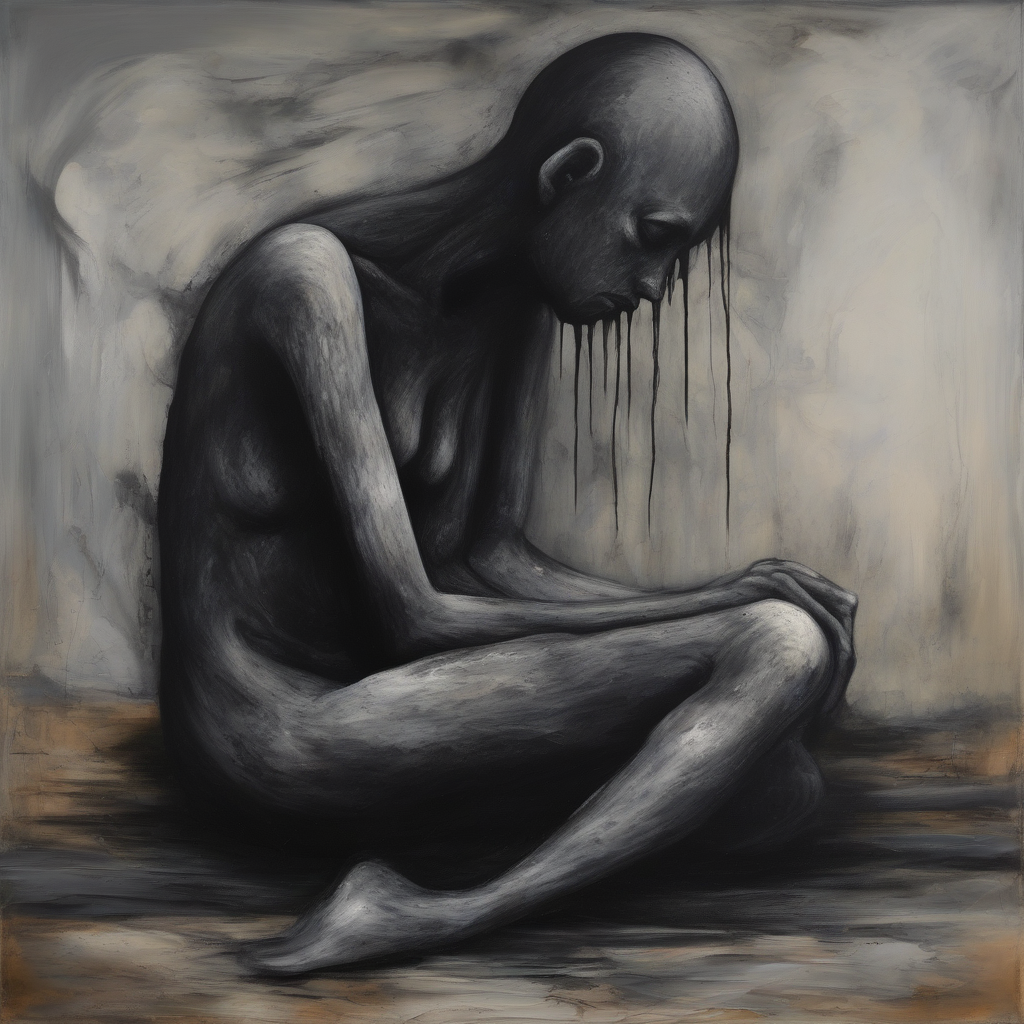


**********************************************************************


In [ ]:
# --- Example Usage ---

if __name__ == "__main__":
    if emotion_model and tokenizer and sd_pipe: 
        print("\n" + "*"*30 + " Running Example Usage " + "*"*30)
        # Example Text 1: Complex negative
        text1 = "A deep sadness washed over me, leaving me feeling lost and alone."
        results1 = process_text_to_art_and_description(text1, emotion_model, tokenizer, sd_pipe, device)

        # Display image if generated (example for notebook)
        if results1 and results1.get("generated_image"):
            print("\nDisplaying Generated Image for Text 1:")
            try:
                from IPython.display import display
                display(results1["generated_image"])
            except ImportError:
                print("(Cannot display image directly - requires IPython environment)")
                # Optionally save the image
                # results1["generated_image"].save("output_image_1.png")

        print("\n" + "*"*70)


****************************** Running Example Usage ******************************

==================== Processing Input Text ====================
Input: "I am happiest today"

--- Step 1: Analyzing Emotions and VAD ---
Raw Top 5 Emotions:
  - sentimental: 0.6382
  - happiness: 0.6163
  - relief: 0.5993
  - grief: 0.5984
  - annoyance: 0.5864
VAD Scores: V=0.5340, A=-0.0677, D=0.1050
Raw emotion names (Prob > 0.1): ['sentimental', 'happiness', 'relief', 'grief', 'annoyance']

--- Step 2: Extracting Keywords ---
Keywords: ['today']

--- Step 3: Patching Emotions ---
Emotion 'content' mapped to symbols: {'symbol': 'rounded shapes, steady patterns, small lights', 'style': 'stable symmetry and warm palette'}
Emotion 'gratitude' mapped to symbols: {'symbol': 'open hands, growing vines, shared light', 'style': 'harmonic, earthy abstract patterns'}
Emotion 'furious' mapped to symbols: {'symbol': 'exploding cores, violent waves, sharp shards', 'style': 'chaotic composition with scorching co

  0%|          | 0/30 [00:00<?, ?it/s]

✅ Image generated successfully.
Image generation successful (PIL Image object created).

--- Step 6: Generating Art Description ---
⏳ Generating art description with Gemini (gemini-1.5-flash)...
✅ Art description generated successfully.
Gemini Description:
The canvas explodes with a chaotic yet strangely harmonious energy.  Vibrant, almost phosphorescent yellows and oranges dominate, punctuated by softer pinks and blues that suggest a tender, sentimental undercurrent.  Thick impasto strokes, like joyous, erratic brushstrokes of relief, build a textured surface, almost tactile in its exuberance.  Shapes are fragmented, levitating forms that defy gravity—amorphous swirls and jagged shards seemingly held in precarious balance.  A sense of unease permeates this celebration;  the viewer feels the unsettling gaze of unseen presences, a subtle tension woven into the vibrant tapestry of happiness. The overall effect is one of ecstatic turmoil, a powerful emotional paradox where overwhelming jo

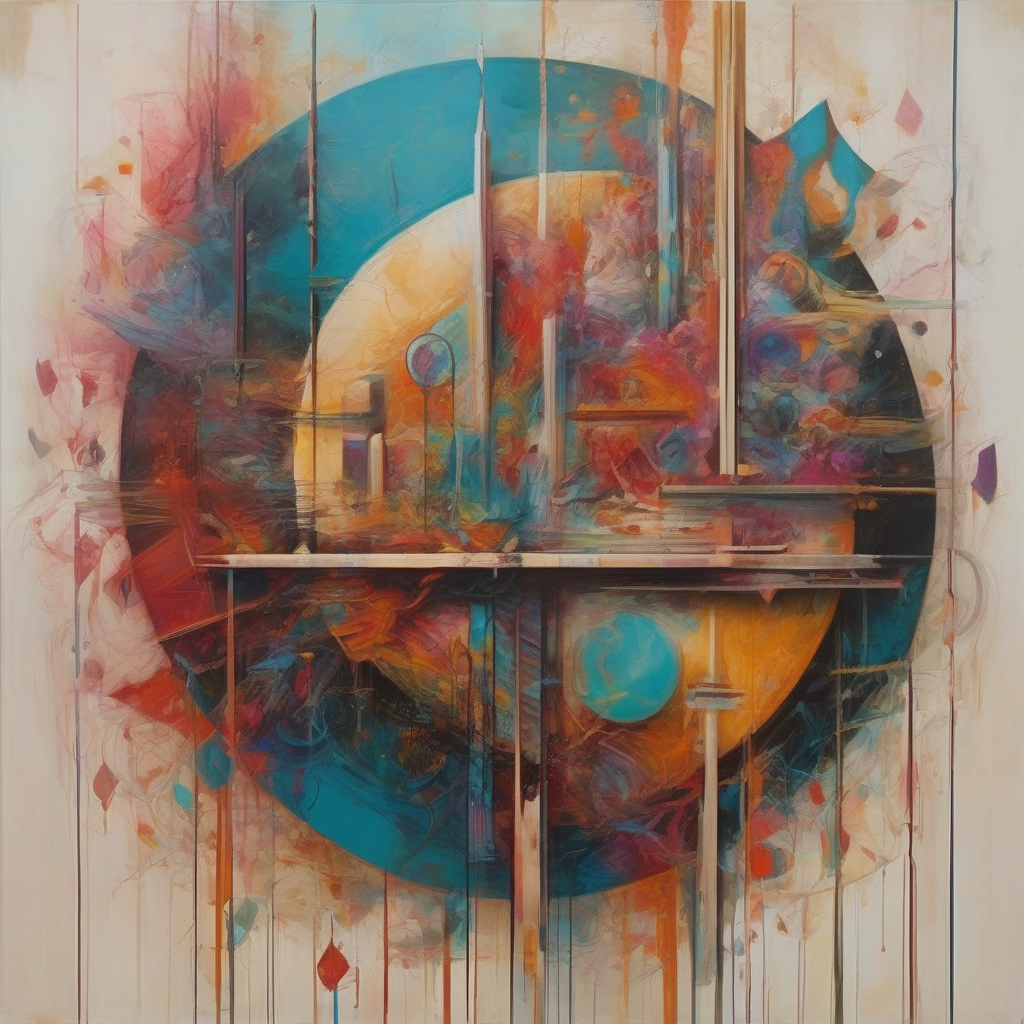


**********************************************************************


In [62]:
# --- Example Usage ---

if __name__ == "__main__":
    # Ensure all models and resources are loaded before calling this
    if emotion_model and tokenizer and sd_pipe: # Check critical components
        print("\n" + "*"*30 + " Running Example Usage " + "*"*30)
        # Example Text 1: Complex negative
        text1 = "I am happiest today"
        results1 = process_text_to_art_and_description(text1, emotion_model, tokenizer, sd_pipe, device)

        # Display image if generated (example for notebook)
        if results1 and results1.get("generated_image"):
            print("\nDisplaying Generated Image for Text 1:")
            try:
                from IPython.display import display
                display(results1["generated_image"])
            except ImportError:
                print("(Cannot display image directly - requires IPython environment)")
                # Optionally save the image
                # results1["generated_image"].save("output_image_1.png")

        print("\n" + "*"*70)